# Quasi-criticality in the Cortex

In [1]:
'''Setup notebook environment -q flag suppresses output, if you want to see it, remove the -q flag'''
# %pip install -r requirements.txt -q
from utils.plotting_utils import *
from utils.data_utils import *
from utils.utils import *
from branching import BranchingNeurons
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import powerlaw

## Branching model

In [ ]:
TESTING = False
file = 'data/branching_data_final.csv'
if not os.path.exists(file) or TESTING:
    if TESTING:
        os.remove(file)
    for branching_ratio in tqdm(np.logspace(np.log10(0.5), np.log10(5), 20)):
        kwargs = {
            'N': 25,
            'max_neighbors': 5,
            'branching_ratio': branching_ratio,
            'visual': False,
        }
        data = simulate(BranchingNeurons, n_runs=1, duration=10000, **kwargs)
        write_data(data, file)


In [ ]:
data = pd.read_csv(file, header=0, index_col=0)
data['mean_density'] = data['density'].apply(float)
data['evalanche_duration'] = data['evalanche_duration'].apply(str_to_list)
data['evalanche_size'] = data['evalanche_size'].apply(str_to_list)

data['density_duration'] = data.apply(lambda x: get_density(x['evalanche_duration'])[0], axis=1)
data['density_size'] = data.apply(lambda x: get_density(x['evalanche_size'])[0], axis=1)
data['values_duration'] = data.apply(lambda x: get_density(x['evalanche_duration'])[1], axis=1)
data['values_size'] = data.apply(lambda x: get_density(x['evalanche_size'])[1], axis=1)

data.head()


In [ ]:
grouped_branching = data.groupby('branching_ratio').mean(numeric_only=True)
critical_point = closest_index_to_value(grouped_branching.index, 1)
critical_data = grouped_branching.loc[grouped_branching.index == grouped_branching.index[critical_point]]


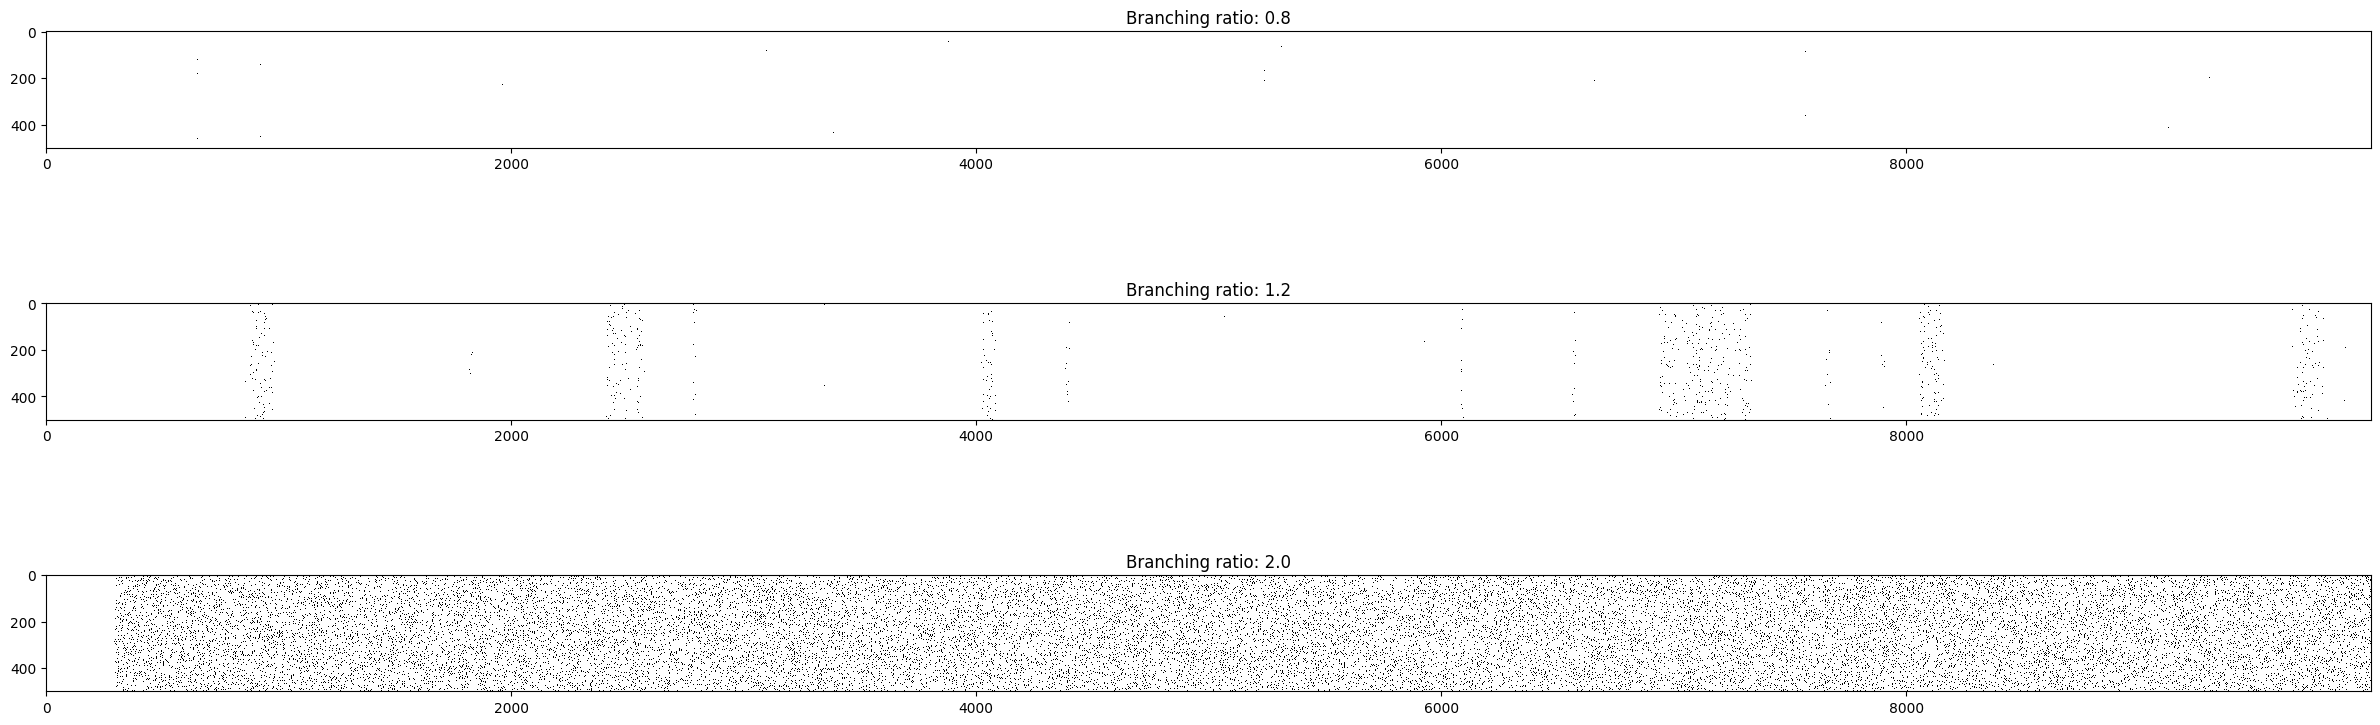

In [3]:
kwargs = {
    'N': 500,
    'max_neighbors': 28,
    'branching_ratio': None,
    'visual': False,
}
plot_activity_per_time_step(10000, **kwargs)

In [ ]:
plt.scatter(grouped_branching.index, grouped_branching['emperical_branching_ratio'], label='Branching ratio')
plt.plot(np.linspace(np.min(grouped_branching.index), np.max(grouped_branching.index), 100), np.linspace(0, np.max(grouped_branching.index), 100), label='1:1 line', color='black', linestyle='--' , alpha=0.5)
plt.xlabel('Branching ratio')
plt.ylabel('Emperical branching ratio')
plt.legend()
plt.show()

In [ ]:
plt.plot(grouped_branching.index, grouped_branching['mean_density'])
plt.scatter(grouped_branching.index, grouped_branching['mean_density'])

plt.scatter(grouped_branching.index.values[critical_point], grouped_branching['mean_density'].values[critical_point], c='r')
plt.text(grouped_branching.index.values[critical_point] + 0.2, grouped_branching['mean_density'].values[critical_point], 'Critical Point')
plt.xlabel('Branching Ratio')
plt.xlim(0.5, 3)
plt.ylabel('Mean Density')
plt.title('Mean Density vs Branching Ratio')
plt.show()

In [ ]:

def loglog_plotting(type: str, data: pd.DataFrame, grouped_branching: pd.DataFrame):
    fig, ax =plt.subplots(3,3, figsize=(15,15))
    ax = ax.ravel()
    for i in range(9):
        offset = 4
        all_critical_points =  data.loc[data['branching_ratio'] == grouped_branching.index[offset+i]]
        all_data = np.concatenate(all_critical_points[type].values)
        all_data = all_data[all_data > 0]

        fit = powerlaw.Fit(all_data, verbose=False)
        x_values = np.linspace(0, max(all_data), 100)
        fitted_line =  fit.xmin*x_values ** -fit.alpha



        powerlaw.plot_pdf(all_data, ax=ax[i], color='red', label='Empirical data' , linestyle='None', marker='o', markersize=3, alpha=0.5)
        ax[i].plot(fitted_line, color='black', linestyle='--', label='Power law fit')

        ax[i].set_title(f'Branching ratio: {grouped_branching.index[offset+i]:.2f}')
        ax[i].text(0.6, 0.9, f'Alpha: {fit.alpha:.2f}\n ', transform=ax[i].transAxes)
        ax[i].set_xlabel(type.split('_')[0].capitalize() + ' ' + type.split('_')[1])
        ax[i].set_ylabel('Frequency')
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_xlim([1, 1e3])
        ax[i].set_ylim([1e-5, 1e0])

    plt.show()
        

In [ ]:

loglog_plotting('evalanche_duration', data, grouped_branching)
loglog_plotting('evalanche_size', data, grouped_branching)

## BTW-like model

In [ ]:
settings1 = [
    {"name": "round_spiral", "params": {"height": 4, "refractory_period": 5, "probability_of_spontaneous_activity": 0.02, "max_distance": 3, "random_connection": False}},
    {"name": "pulse_wave", "params": {"height": 5, "refractory_period": 4, "probability_of_spontaneous_activity": 0.03, "max_distance": 3, "random_connection": False}},
    {"name": "synchronous", "params": {"height": 3, "refractory_period": 5, "probability_of_spontaneous_activity": 0.015, "max_distance": 2.5, "random_connection": True}},
    {"name": "oscillatory", "params": {"height": 2, "refractory_period": 4, "probability_of_spontaneous_activity": 0.02, "max_distance": 3, "random_connection": False}},
    {"name": "repeating", "params": {"height": 2, "refractory_period": 4, "probability_of_spontaneous_activity": 0.02, "max_distance": 3, "random_connection": True}},
    {"name": "random", "params": {"height": 5, "refractory_period": 5, "probability_of_spontaneous_activity": 0.02, "max_distance": 3, "random_connection": False}}]

In [ ]:
# Data collection
for setting in settings1:
    btw = BTW(grid_size=[50, 50], **setting['params'])
    btw.run(10000)
    path = f"data/spikes_btw_{setting['name']}.csv"
    btw.write_data(path)

In [ ]:
# Plot avg_spike_density vs. m
paths = [f"data/spikes_btw_{setting['name']}.csv" for setting in settings1]
size = 50
spike_density_plot(paths, size)

In [ ]:
settings2 = [{"name": f"ref{ref}thresh{thresh}", 
            "params": {"height": thresh, 
                        "refractory_period": ref, 
                        "probability_of_spontaneous_activity": 0.02, 
                        "max_distance": 3, 
                        "random_connection": False}}
            for ref in range(1, 8) for thresh in range(1, 7)]

In [ ]:
# Data collection
for setting in settings2:
    btw = BTW(grid_size=[50, 50], **setting['params'])
    btw.init_grid("random", 4)
    btw.run(10000)
    path = f"data/spikes_btw_ref_thresh/spikes_btw_{setting['name']}.csv"
    btw.write_data(path)

In [ ]:
# Plot avg_spike_density vs. m
paths = [f"data/spikes_btw_ref_thresh/spikes_btw_{setting['name']}.csv" for setting in settings2]
size = 50
spike_density_plot(paths, size)


**Draft**

In [ ]:
a = [1, 3, 3]
b = [0, 3, 2]
a-b

In [ ]:
import numpy as np
import pandas as pd
args = {"one": 4, "two": 5, "three": 0.02}
args_df = pd.DataFrame(args, index=[0])
results_df = pd.DataFrame({"spikes_total": np.array([0, 3, 3]), 
                        "spikes_neighbours": np.array([0, 1, 1]), 
                        "spikes_input": np.array([0, 3, 3]) - np.array([0, 1, 1])})
combined_df = pd.concat([args_df, results_df], axis=1)
print(combined_df)

In [ ]:
results = load_data_csv("path")

In [ ]:
print(results.shape)